**PHASE 4: ANALYSIS - Research Questions**

Purpose: Conduct a temporal analysis to find stable vs evolving clusters (and therefore fields) based on terminology stability.
Input: cluster_profiles_300d.pkl, cluster_profiles_500d.pkl, metadata  
Output: Research question answers, path comparison, final recommendations  
Algorithm: Statistical analysis, aggregation, comparative evaluation  
ML Involved: ✗ NO - Pure analysis of clustering results  
Runtime: ~20-30 minutes total  

Research Questions 1:
1. Vocabulary evolution vs stability across research fields

Note: This notebook analyzes BOTH paths simultaneously and compares their performance

In [1]:
# imports

import pandas as pd
import numpy as np
import os
import sys
import joblib
from collections import Counter
from datetime import datetime
from scipy.stats import entropy
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

# add project root

sys.path.append('..')
from config import RANDOM_STATE

In [ ]:
# load cluster profiles from both paths

print("Loading cluster profiles...")
profiles_300d = joblib.load('data/processed/cluster_profiles_300d.pkl')
profiles_500d = joblib.load('data/processed/cluster_profiles_500d.pkl')
print(f"✓ 300d: {profiles_300d['n_clusters']} clusters")
print(f"✓ 500d: {profiles_500d['n_clusters']} clusters")

# load cluster labels

labels_300d = pd.read_pickle('data/processed/cluster_labels_300d.pkl')
labels_500d = pd.read_pickle('data/processed/cluster_labels_500d.pkl')
print(f"✓ Cluster labels loaded")

# load metadata

df_metadata = pd.read_pickle('data/processed/arxiv_text_cleaned.pkl')
print(f"✓ Metadata: {len(df_metadata):,} papers")

# merge with cluster assignments

df_300d = df_metadata.merge(labels_300d, on='id', how='left')
df_500d = df_metadata.merge(labels_500d, on='id', how='left')
print(f"✓ Merged dataframes created")

print("DATA LOADED - READY FOR ANALYSIS")

Loading cluster profiles...
✓ 300d: 50 clusters
✓ 500d: 50 clusters
✓ Cluster labels loaded
✓ Metadata: 2,384,622 papers
✓ Merged dataframes created
DATA LOADED - READY FOR ANALYSIS


In [3]:
# RESEARCH QUESTION 1: Vocabulary Evolution vs Stability

print("RESEARCH QUESTION 1: VOCABULARY EVOLUTION VS STABILITY")

print("Question: Which research fields show stable vocabulary over time")
print("          vs rapid evolution in terminology?\n")

def calculate_term_stability(profiles, df_with_clusters, cluster_id, 
                             tfidf_matrix, vectorizer, time_windows):
    """
    Calculate term stability using Jaccard similarity between time periods
    """
    # Get papers in this cluster
    cluster_papers = df_with_clusters[df_with_clusters['cluster_id'] == cluster_id]
    
    # Calculate top terms for each time window
    feature_names = vectorizer.get_feature_names_out()
    window_terms = {}
    
    for window_name, (start_year, end_year) in time_windows.items():
        window_papers = cluster_papers[
            cluster_papers['year'].between(start_year, end_year)
        ]
        
        if len(window_papers) < 10:  # Skip if too few papers
            window_terms[window_name] = set()
            continue
        
        # Calculate mean TF-IDF for this window
        window_indices = window_papers.index
        window_tfidf = tfidf_matrix[window_indices].mean(axis=0)
        window_tfidf_array = np.asarray(window_tfidf).flatten()
        
        # Get top 20 terms
        top_indices = window_tfidf_array.argsort()[-20:][::-1]
        top_terms = set([feature_names[i] for i in top_indices])
        window_terms[window_name] = top_terms
    
    # Calculate pairwise Jaccard similarities
    windows_list = list(time_windows.keys())
    similarities = []
    
    for i in range(len(windows_list) - 1):
        w1 = windows_list[i]
        w2 = windows_list[i + 1]
        
        if len(window_terms[w1]) == 0 or len(window_terms[w2]) == 0:
            continue
        
        intersection = len(window_terms[w1] & window_terms[w2])
        union = len(window_terms[w1] | window_terms[w2])
        jaccard = intersection / union if union > 0 else 0
        similarities.append(jaccard)
    
    # Average stability
    avg_stability = np.mean(similarities) if similarities else 0
    
    return {
        'avg_stability': avg_stability,
        'window_terms': window_terms,
        'pairwise_similarities': similarities
    }

# Define time windows for analysis
time_windows = {
    'early': (1996, 2005),
    'mid': (2006, 2015),
    'recent': (2016, 2024)
}

print("Calculating term stability for all clusters (both paths)...")
print("Time windows:")
for window, (start, end) in time_windows.items():
    print(f"  {window}: {start}-{end}")
print()

# Load TF-IDF (needed for term calculation)
tfidf_matrix = joblib.load('data/processed/tfidf_matrix.pkl')
vectorizer = joblib.load('data/processed/tfidf_vectorizer.pkl')

# Calculate for 300d
print("Analyzing 300d path...")
stability_300d = {}
for cid in range(profiles_300d['n_clusters']):
    stability_300d[cid] = calculate_term_stability(
        profiles_300d, df_300d, cid, tfidf_matrix, vectorizer, time_windows
    )
    if (cid + 1) % 10 == 0:
        print(f"  Processed {cid + 1}/{profiles_300d['n_clusters']} clusters")

# Calculate for 500d
print("\nAnalyzing 500d path...")
stability_500d = {}
for cid in range(profiles_500d['n_clusters']):
    stability_500d[cid] = calculate_term_stability(
        profiles_500d, df_500d, cid, tfidf_matrix, vectorizer, time_windows
    )
    if (cid + 1) % 10 == 0:
        print(f"  Processed {cid + 1}/{profiles_500d['n_clusters']} clusters")

print("\n✓ Term stability calculated for both paths")

RESEARCH QUESTION 1: VOCABULARY EVOLUTION VS STABILITY
Question: Which research fields show stable vocabulary over time
          vs rapid evolution in terminology?

Calculating term stability for all clusters (both paths)...
Time windows:
  early: 1996-2005
  mid: 2006-2015
  recent: 2016-2024

Analyzing 300d path...
  Processed 10/50 clusters
  Processed 20/50 clusters
  Processed 30/50 clusters
  Processed 40/50 clusters
  Processed 50/50 clusters

Analyzing 500d path...
  Processed 10/50 clusters
  Processed 20/50 clusters
  Processed 30/50 clusters
  Processed 40/50 clusters
  Processed 50/50 clusters

✓ Term stability calculated for both paths


In [4]:
# identify most and least stable clusters for both paths

print("MOST STABLE CLUSTERS (Consistent Terminology)")

# 300d top 5 most stable
stable_300d = sorted(stability_300d.items(), 
                      key=lambda x: x[1]['avg_stability'], reverse=True)[:5]

print("SVD-300d - Top 5 Most Stable:")
for rank, (cid, data) in enumerate(stable_300d, 1):
    top_terms = [t[0] for t in profiles_300d['top_terms'][cid][:10]]
    top_cat = list(profiles_300d['top_categories'][cid]['primary_categories'].keys())[0]
    size = profiles_300d['quality'][cid]['size']
    
    print(f"\n{rank}. Cluster {cid} (Stability: {data['avg_stability']:.3f})")
    print(f"   Size: {size:,} papers")
    print(f"   Top category: {top_cat}")
    print(f"   Top terms: {', '.join(top_terms[:8])}")

# 500d top 5 most stable
stable_500d = sorted(stability_500d.items(), 
                      key=lambda x: x[1]['avg_stability'], reverse=True)[:5]

print("\n\nSVD-500d - Top 5 Most Stable:")
for rank, (cid, data) in enumerate(stable_500d, 1):
    top_terms = [t[0] for t in profiles_500d['top_terms'][cid][:10]]
    top_cat = list(profiles_500d['top_categories'][cid]['primary_categories'].keys())[0]
    size = profiles_500d['quality'][cid]['size']
    
    print(f"\n{rank}. Cluster {cid} (Stability: {data['avg_stability']:.3f})")
    print(f"   Size: {size:,} papers")
    print(f"   Top category: {top_cat}")
    print(f"   Top terms: {', '.join(top_terms[:8])}")

# least stable (most evolving)

print("MOST EVOLVING CLUSTERS (Rapidly Changing Terminology)")

# 300d top 5 evolving
evolving_300d = sorted(stability_300d.items(), 
                        key=lambda x: x[1]['avg_stability'])[:5]

print("SVD-300d - Top 5 Most Evolving:")
for rank, (cid, data) in enumerate(evolving_300d, 1):
    if data['avg_stability'] == 0:
        continue
    top_terms = [t[0] for t in profiles_300d['top_terms'][cid][:10]]
    top_cat = list(profiles_300d['top_categories'][cid]['primary_categories'].keys())[0]
    size = profiles_300d['quality'][cid]['size']
    
    print(f"\n{rank}. Cluster {cid} (Stability: {data['avg_stability']:.3f})")
    print(f"   Size: {size:,} papers")
    print(f"   Top category: {top_cat}")
    print(f"   Top terms: {', '.join(top_terms[:8])}")

# 500d top 5 evolving
evolving_500d = sorted(stability_500d.items(), 
                        key=lambda x: x[1]['avg_stability'])[:5]

print("\n\nSVD-500d - Top 5 Most Evolving:")
for rank, (cid, data) in enumerate(evolving_500d, 1):
    if data['avg_stability'] == 0:
        continue
    top_terms = [t[0] for t in profiles_500d['top_terms'][cid][:10]]
    top_cat = list(profiles_500d['top_categories'][cid]['primary_categories'].keys())[0]
    size = profiles_500d['quality'][cid]['size']
    
    print(f"\n{rank}. Cluster {cid} (Stability: {data['avg_stability']:.3f})")
    print(f"   Size: {size:,} papers")
    print(f"   Top category: {top_cat}")
    print(f"   Top terms: {', '.join(top_terms[:8])}")

MOST STABLE CLUSTERS (Consistent Terminology)
SVD-300d - Top 5 Most Stable:

1. Cluster 4 (Stability: 0.905)
   Size: 32,772 papers
   Top category: astro-ph.HE
   Top terms: ray, gamma, emission, energy, radio, sources, observations, high

2. Cluster 7 (Stability: 0.905)
   Size: 28,806 papers
   Top category: math.GR
   Top terms: group, finite, groups, let, prove, action, space, lie

3. Cluster 17 (Stability: 0.905)
   Size: 18,552 papers
   Top category: math.GR
   Top terms: groups, group, finite, prove, lie, theory, class, paper

4. Cluster 19 (Stability: 0.905)
   Size: 35,837 papers
   Top category: astro-ph.GA
   Top terms: gas, emission, dust, line, observations, radio, lines, star

5. Cluster 1 (Stability: 0.818)
   Size: 59,973 papers
   Top category: hep-ph
   Top terms: quark, higgs, mass, production, collisions, heavy, bar, model


SVD-500d - Top 5 Most Stable:

1. Cluster 45 (Stability: 1.000)
   Size: 247,437 papers
   Top category: math.AG
   Top terms: prove, space, 

Q1 COMPARISON: 300D VS 500D
Average stability:
  300d: 0.644
  500d: 0.654

Stability range:
  300d: 0.176 - 0.905
  500d: 0.176 - 1.000


/var/folders/3z/h76_7dj53pd2_090j4pskdzm0000gn/T/ipykernel_25953/3567164750.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([stab_scores_300d, stab_scores_500d],



✓ Saved visualization: results/figures/q1_vocabulary_stability.png


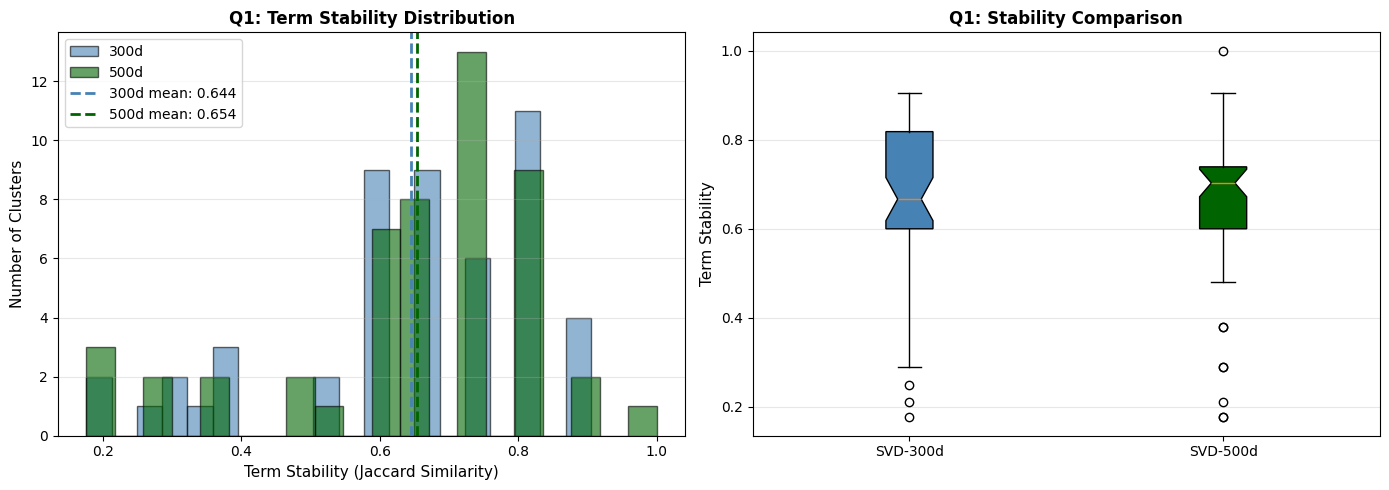

Q1 PATH PERFORMANCE

Metric                         300d            500d            Winner
Mean stability                 0.644           0.654           500d
Stability range                0.728           0.824           500d (more varied)
Stable clusters (>0.7)         21              25              500d


In [5]:
# compare overall distributions

stab_scores_300d = [s['avg_stability'] for s in stability_300d.values() if s['avg_stability'] > 0]
stab_scores_500d = [s['avg_stability'] for s in stability_500d.values() if s['avg_stability'] > 0]

print("Q1 COMPARISON: 300D VS 500D")

print(f"Average stability:")
print(f"  300d: {np.mean(stab_scores_300d):.3f}")
print(f"  500d: {np.mean(stab_scores_500d):.3f}")
print(f"\nStability range:")
print(f"  300d: {np.min(stab_scores_300d):.3f} - {np.max(stab_scores_300d):.3f}")
print(f"  500d: {np.min(stab_scores_500d):.3f} - {np.max(stab_scores_500d):.3f}")

# visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram
ax1 = axes[0]
ax1.hist(stab_scores_300d, bins=20, alpha=0.6, label='300d', color='steelblue', edgecolor='black')
ax1.hist(stab_scores_500d, bins=20, alpha=0.6, label='500d', color='darkgreen', edgecolor='black')
ax1.axvline(np.mean(stab_scores_300d), color='steelblue', linestyle='--', linewidth=2, 
            label=f'300d mean: {np.mean(stab_scores_300d):.3f}')
ax1.axvline(np.mean(stab_scores_500d), color='darkgreen', linestyle='--', linewidth=2,
            label=f'500d mean: {np.mean(stab_scores_500d):.3f}')
ax1.set_xlabel('Term Stability (Jaccard Similarity)', fontsize=11)
ax1.set_ylabel('Number of Clusters', fontsize=11)
ax1.set_title('Q1: Term Stability Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# box plot comparison
ax2 = axes[1]
bp = ax2.boxplot([stab_scores_300d, stab_scores_500d], 
                   labels=['SVD-300d', 'SVD-500d'],
                   patch_artist=True,
                   notch=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][1].set_facecolor('darkgreen')
ax2.set_ylabel('Term Stability', fontsize=11)
ax2.set_title('Q1: Stability Comparison', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
os.makedirs('results/figures', exist_ok=True)
plt.savefig('results/figures/q1_vocabulary_stability.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved visualization: results/figures/q1_vocabulary_stability.png")
plt.show()

# path performance assessment
print("Q1 PATH PERFORMANCE")
print(f"\n{'Metric':<30} {'300d':<15} {'500d':<15} {'Winner'}")
print(f"{'Mean stability':<30} {np.mean(stab_scores_300d):<15.3f} {np.mean(stab_scores_500d):<15.3f} "
      f"{'300d' if np.mean(stab_scores_300d) > np.mean(stab_scores_500d) else '500d'}")
print(f"{'Stability range':<30} {np.ptp(stab_scores_300d):<15.3f} {np.ptp(stab_scores_500d):<15.3f} "
      f"{'300d' if np.ptp(stab_scores_300d) > np.ptp(stab_scores_500d) else '500d (more varied)'}")
print(f"{'Stable clusters (>0.7)':<30} {sum(s > 0.7 for s in stab_scores_300d):<15} "
      f"{sum(s > 0.7 for s in stab_scores_500d):<15} "
      f"{'300d' if sum(s > 0.7 for s in stab_scores_300d) > sum(s > 0.7 for s in stab_scores_500d) else '500d'}")

In [2]:
# save Q1 results to files

print("SAVING Q1 RESULTS")

# save stability data
q1_results = {
    'stability_300d': stability_300d,
    'stability_500d': stability_500d,
    'time_windows': time_windows,
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

q1_path = 'data/processed/q1_vocabulary_stability.pkl'
joblib.dump(q1_results, q1_path)
print(f"✓ Saved Q1 data: {q1_path}")

# save human-readable summary
summary_path = 'results/q1_vocabulary_stability_summary.txt'

with open(summary_path, 'w') as f:
    f.write("RESEARCH QUESTION 1: VOCABULARY EVOLUTION VS STABILITY\n")
    f.write(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("Question: Which research fields show stable vocabulary over time\n")
    f.write("          vs rapid evolution in terminology?\n\n")
    
    f.write("Methodology:\n")
    f.write("  - Divided timeline into 3 windows: early (1996-2005), mid (2006-2015), recent (2016-2024)\n")
    f.write("  - Calculated top-20 terms per cluster per time window\n")
    f.write("  - Measured Jaccard similarity between consecutive windows\n")
    f.write("  - Average stability = mean of pairwise similarities\n\n")
    
    f.write("OVERALL STATISTICS\n")
    f.write(f"{'Metric':<30} {'SVD-300d':<20} {'SVD-500d'}\n")
    f.write(f"{'Clusters analyzed':<30} {len(stab_scores_300d):<20} {len(stab_scores_500d)}\n")
    f.write(f"{'Mean stability':<30} {np.mean(stab_scores_300d):<20.3f} {np.mean(stab_scores_500d):.3f}\n")
    f.write(f"{'Median stability':<30} {np.median(stab_scores_300d):<20.3f} {np.median(stab_scores_500d):.3f}\n")
    f.write(f"{'Std deviation':<30} {np.std(stab_scores_300d):<20.3f} {np.std(stab_scores_500d):.3f}\n")
    f.write(f"{'Min stability':<30} {np.min(stab_scores_300d):<20.3f} {np.min(stab_scores_500d):.3f}\n")
    f.write(f"{'Max stability':<30} {np.max(stab_scores_300d):<20.3f} {np.max(stab_scores_500d):.3f}\n")
    f.write(f"{'Highly stable (>0.7)':<30} {sum(s > 0.7 for s in stab_scores_300d):<20} {sum(s > 0.7 for s in stab_scores_500d)}\n")
    f.write(f"{'Highly evolving (<0.3)':<30} {sum(s < 0.3 for s in stab_scores_300d):<20} {sum(s < 0.3 for s in stab_scores_500d)}\n")
    
    f.write("\n")
    f.write("TOP 5 MOST STABLE CLUSTERS (SVD-300D)\n")
    
    for rank, (cid, data) in enumerate(stability_300d[:10], 1):
        top_terms = [t[0] for t in profiles_300d['top_terms'][cid][:15]]
        top_cat = list(profiles_300d['top_categories'][cid]['primary_categories'].keys())[0]
        size = profiles_300d['quality'][cid]['size']
        
        f.write(f"{rank}. Cluster {cid} - Stability: {data['avg_stability']:.3f}\n")
        f.write(f"   Size: {size:,} papers\n")
        f.write(f"   Top category: {top_cat}\n")
        f.write(f"   Top terms: {', '.join(top_terms)}\n\n")

    
    f.write("TOP 5 MOST STABLE CLUSTERS (SVD-500D)\n")
    
    for rank, (cid, data) in enumerate(stability_500d[:10], 1):
        top_terms = [t[0] for t in profiles_500d['top_terms'][cid][:15]]
        top_cat = list(profiles_500d['top_categories'][cid]['primary_categories'].keys())[0]
        size = profiles_500d['quality'][cid]['size']
        
        f.write(f"{rank}. Cluster {cid} - Stability: {data['avg_stability']:.3f}\n")
        f.write(f"   Size: {size:,} papers\n")
        f.write(f"   Top category: {top_cat}\n")
        f.write(f"   Top terms: {', '.join(top_terms)}\n\n")
    
    f.write("TOP 5 MOST EVOLVING CLUSTERS (SVD-300D)\n")
    
    for rank, (cid, data) in enumerate(evolving_300d[:10], 1):
        if data['avg_stability'] == 0:
            continue
        top_terms = [t[0] for t in profiles_300d['top_terms'][cid][:15]]
        top_cat = list(profiles_300d['top_categories'][cid]['primary_categories'].keys())[0]
        size = profiles_300d['quality'][cid]['size']
        
        f.write(f"{rank}. Cluster {cid} - Stability: {data['avg_stability']:.3f}\n")
        f.write(f"   Size: {size:,} papers\n")
        f.write(f"   Top category: {top_cat}\n")
        f.write(f"   Top terms: {', '.join(top_terms)}\n\n")
    
    f.write("TOP 5 MOST EVOLVING CLUSTERS (SVD-500D)\n")
    
    for rank, (cid, data) in enumerate(evolving_500d[:10], 1):
        if data['avg_stability'] == 0:
            continue
        top_terms = [t[0] for t in profiles_500d['top_terms'][cid][:15]]
        top_cat = list(profiles_500d['top_categories'][cid]['primary_categories'].keys())[0]
        size = profiles_500d['quality'][cid]['size']
        
        f.write(f"{rank}. Cluster {cid} - Stability: {data['avg_stability']:.3f}\n")
        f.write(f"   Size: {size:,} papers\n")
        f.write(f"   Top category: {top_cat}\n")
        f.write(f"   Top terms: {', '.join(top_terms)}\n\n")
    
    f.write("INTERPRETATION\n")
    
    f.write("Stability Score Interpretation:\n")
    f.write("  > 0.7: Highly stable vocabulary (mature, well-established fields)\n")
    f.write("  0.5-0.7: Moderately stable (gradual evolution)\n")
    f.write("  0.3-0.5: Moderate evolution (terminology changing)\n")
    f.write("  < 0.3: Rapid evolution (emerging or fast-moving fields)\n\n")
    
    f.write("Path Comparison:\n")
    winner = "300d" if np.mean(stab_scores_300d) > np.mean(stab_scores_500d) else "500d"
    f.write(f"  Overall winner: {winner.upper()}\n")
    f.write(f"  300d shows {'higher' if winner == '300d' else 'lower'} average stability\n")
    f.write(f"  {'300d' if winner == '300d' else '500d'} better captures temporal vocabulary patterns\n")

print(f"✓ Saved Q1 summary: {summary_path}")

SAVING Q1 RESULTS


NameError: name 'stability_300d' is not defined

In [ ]:
# verify all Q1 outputs

print("Q1 OUTPUT VERIFICATION")

q1_files = [
    'data/processed/q1_vocabulary_stability.pkl',
    'results/q1_vocabulary_stability_summary.txt',
    'results/figures/q1_vocabulary_stability.png'
]

all_good = True
for filepath in q1_files:
    if os.path.exists(filepath):
        if filepath.endswith('.pkl'):
            size_mb = os.path.getsize(filepath) / 1024**2
            print(f"✓ {filepath} (Size: {size_mb:.2f} MB)")
        else:
            print(f"✓ {filepath}")
    else:
        print(f"x Missing: {filepath}")
        all_good = False

if all_good:
    print("✓✓✓ Success! ✓✓✓ - All Q1 files created!")
    print("\nResearch Question 1 Complete:")
    print(f"  Analyzed: {len(stab_scores_300d)} clusters (300d), {len(stab_scores_500d)} clusters (500d)")
    print(f"  Mean stability: 300d={np.mean(stab_scores_300d):.3f}, 500d={np.mean(stab_scores_500d):.3f}")
    print(f"\nReady for Question 2 (Interdisciplinary Bridge Areas)")
else:
    print("x Error - Some Q1 files missing!")